# 6.5.2 Ridge Regression and the Lasso
We will use the `glmnet` package in order to perform ridge regression and the lasso. The main function in this package is `glmnet()`, which can be used to fit ridge regression models, lasso models, and more. This function has slightly different syntax from other model-fitting functions that we have encountered thus far in this book. In particular, we must pass in an `x` matrix as well ad a `y` vector, and we do not use the `y ~ x~ syntax. We will now perform ridge regression and the lasso in order to predict `Salary` on the `Hitters` data. Before proceeding ensure that the missing values have been removed fromt he data, as described in Section 6.5.1.

In [1]:
library(ISLR2)

In [2]:
Hitters <- na.omit(Hitters)
x <- model.matrix(Salary ~ ., Hitters)[,-1]
y <- Hitters$Salary

The `model.matrix()` function is particularly useful for creating `x`; not only does it produce a matrix corresponding to the 19 predictors but it also automatically transforms any qualitative variables into dummy variables. The latter property is important because `glmnet()` can only take numerical quantitative inputs.

## Ridge Regression
The `glmnet()` function has an `alpha` argument that determines what type of model is fit. If `alpha=0` then a ridge regression model is fit, and if `alpha=1` then a lasso model is fit. We first fit a ridge regression model.

In [3]:
library(glmnet)
grid <- 10^seq(10, -2, length = 100)
ridge.mod <- glmnet(x, y, alpha = 0, lambda = grid)

Loading required package: Matrix

Loaded glmnet 4.1-8



By default the `glmnet()` function performs ridge regression for an automatically selected range of $\lambda$ values. However, here we have chosen to implement the function over a grid of values ranging from $\lambda=10^{10}$ to $\lambda=10^{-2}$, essentially covering the full range of scenarios from the null model containing only the intercept, to the least squares fit. As we will see, we can also compute model fits for a particular value of $\lambda$ that is not one of the original `grid` values. Note that by default, the `glmnet()` function standardizes the variables so that they are on the same scale. To turn off this default setting, use the argument `standardize = FALSE`.  

Associated with each value of $\lambda$ is a vector of ridge regression coefficients, stored in a matrix that can be accessed by `coef()`. In this case, it is a $20\times100$ matrix, with 20 rows (one for each predictor, plus an intercept) and 100 columns (one for each value of $\lambda$).

In [4]:
dim(coef(ridge.mod))

[1]  20 100

We expect the coefficient estimates to be much smaller, in terms of $\ell_2$ norm, when a large value of $\lambda$ is used, as compared to when a small value of $\lambda$ is used. These are the coefficients when $\lambda=11,498$, along with their $\ell_2$ norm:

In [5]:
ridge.mod$lambda[50]

[1] 11497.57

In [6]:
coef(ridge.mod)[,50]

(Intercept)         AtBat          Hits         HmRun          Runs 
407.356050200   0.036957182   0.138180344   0.524629976   0.230701523 
          RBI         Walks         Years        CAtBat         CHits 
  0.239841459   0.289618741   1.107702929   0.003131815   0.011653637 
       CHmRun         CRuns          CRBI        CWalks       LeagueN 
  0.087545670   0.023379882   0.024138320   0.025015421   0.085028114 
    DivisionW       PutOuts       Assists        Errors    NewLeagueN 
 -6.215440973   0.016482577   0.002612988  -0.020502690   0.301433531

In [7]:
sqrt(sum(coef(ridge.mod)[-1, 50]^2))

[1] 6.360612

In contrast, here are the coefficients when $\lambda=705$, along with their $\ell_2$ norm. Note that much larger $\ell_2$ norm of the coefficients associated with this smaller value of $\lambda$.

In [8]:
ridge.mod$lambda[60]

[1] 705.4802

In [9]:
coef(ridge.mod)[,60]

(Intercept)        AtBat         Hits        HmRun         Runs          RBI 
 54.32519950   0.11211115   0.65622409   1.17980910   0.93769713   0.84718546 
       Walks        Years       CAtBat        CHits       CHmRun        CRuns 
  1.31987948   2.59640425   0.01083413   0.04674557   0.33777318   0.09355528 
        CRBI       CWalks      LeagueN    DivisionW      PutOuts      Assists 
  0.09780402   0.07189612  13.68370191 -54.65877750   0.11852289   0.01606037 
      Errors   NewLeagueN 
 -0.70358655   8.61181213

In [10]:
sqrt(sum(coef(ridge.mod)[-1,60]^2))

[1] 57.11001

We can use the `predict()` function for a number of purposes. For instance we can obtain the ridge regression coefficients for a new value of $\lambda$, say $50$.

In [11]:
predict(ridge.mod, s = 50, type = "coefficients")[1:20,]

(Intercept)         AtBat          Hits         HmRun          Runs 
 4.876610e+01 -3.580999e-01  1.969359e+00 -1.278248e+00  1.145892e+00 
          RBI         Walks         Years        CAtBat         CHits 
 8.038292e-01  2.716186e+00 -6.218319e+00  5.447837e-03  1.064895e-01 
       CHmRun         CRuns          CRBI        CWalks       LeagueN 
 6.244860e-01  2.214985e-01  2.186914e-01 -1.500245e-01  4.592589e+01 
    DivisionW       PutOuts       Assists        Errors    NewLeagueN 
-1.182011e+02  2.502322e-01  1.215665e-01 -3.278600e+00 -9.496680e+00

We now split the samples into a training set and a test set in order to estimate the test error of ridge regression and the lasso. There are two common ways to randomly split a data set. The first is to produce a random vector of `TRUE`, `FALSE` elements and select the observations corresponding to `TRUE` for the training data. The second is to randomly choose a subset of numbers between 1 and $n$; these can then be used as the indices for the training observations. The two approaches work equally well. We used the former method in Section 6.5.1. Here we demonstrate the latter approach.  

We first set a random seed so that the results obtained will be reproducible.

In [12]:
set.seed(1)
train <- sample(1:nrow(x), nrow(x) / 2)
test <- (-train)
y.test <- y[test]

Next we fit a ridge regression model on the training set, and evaluate its MSE on the test set, using $\lambda=4$. Note the use of the `predict()` function again. This time we get predictions for a test set, by replacing `type="coefficients"` with the `newx` argument.

In [13]:
ridge.mod <- glmnet(x[train,], y[train], alpha = 0,
                    lambda = grid, thresh = 1e-12)
ridge.pred <- predict(ridge.mod, s = 4, newx = x[test,])
mean((ridge.pred - y.test)^2)

[1] 142199.2

The test MSE is $142,199$. Note that if we had instead simply fit a model with just an intercept, we would have predicted each test observation using the mean of the training observations. In that case, we could compute the test set MSE like this:

In [14]:
mean((mean(y[train]) - y.test)^2)

[1] 224669.9

We could also get the same result by fitting a ridge regression model with a _very_ large value of $\lambda$. Note that `1e10` means $10^{10}$.

In [15]:
ridge.pred <- predict(ridge.mod, s = 1e10, newx = x[test,])
mean((ridge.pred - y.test)^2)

[1] 224669.8

So fitting a ridge regression model with $\lambda=4$ leads to a much lower test MSE than fitting a model with just an intercept. We now check whether there is any benefit to performing ridge regression with $\lambda=4$ instead of just performing least squares regression. Recall that least squares is simply ridge regression with $\lambda = 0$.

In [16]:
ridge.pred <- predict(ridge.mod, s = 0, newx = x[test,], exact = T, x = x[train,], y = y[train])
mean((ridge.pred - y.test)^2)

[1] 168588.6

In [17]:
lm(y~x, subset = train)
predict(ridge.mod, s = 0, exact = T, type = "coefficients", x = x[train,], y = y[train])[1:20,]


Call:
lm(formula = y ~ x, subset = train)

Coefficients:
(Intercept)       xAtBat        xHits       xHmRun        xRuns         xRBI  
   274.0145      -0.3521      -1.6377       5.8145       1.5424       1.1243  
     xWalks       xYears      xCAtBat       xCHits      xCHmRun       xCRuns  
     3.7287     -16.3773      -0.6412       3.1632       3.4008      -0.9739  
      xCRBI      xCWalks     xLeagueN   xDivisionW     xPutOuts     xAssists  
    -0.6005       0.3379     119.1486    -144.0831       0.1976       0.6804  
    xErrors  xNewLeagueN  
    -4.7128     -71.0951  


(Intercept)        AtBat         Hits        HmRun         Runs          RBI 
 274.0200994   -0.3521900   -1.6371383    5.8146692    1.5423361    1.1241837 
       Walks        Years       CAtBat        CHits       CHmRun        CRuns 
   3.7288406  -16.3795195   -0.6411235    3.1629444    3.4005281   -0.9739405 
        CRBI       CWalks      LeagueN    DivisionW      PutOuts      Assists 
  -0.6003976    0.3378422  119.1434637 -144.0853061    0.1976300    0.6804200 
      Errors   NewLeagueN 
  -4.7127879  -71.0898914

In genral, if we want to fit a (unpenalized) least squares model, then we should use the `lm()` function, since that function provides more useful outputs, such as standard errors and p-values for the coefficients.  

In general, instead of arbitrarily choosing $\lambda=4$, it would be better to use cross-valiation to choose the tuning paramter $\lambda$. We can do this using the built-in cross-validation function, `cv.glmnet()`. By default, the function perform ten-fold cross-validation, though this can be changed using the argument `nfolds`. Note that we set a random seed first so our results will be reproducible, since the choice of the cross-valiation folds is random.

[1] 326.0828

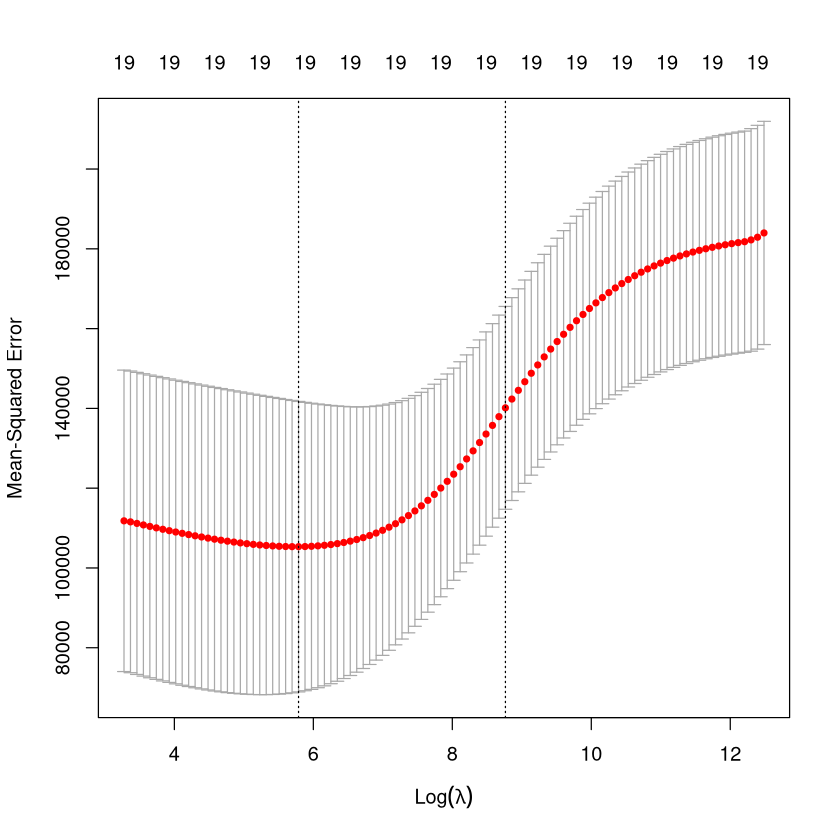

In [18]:
set.seed(1)
cv.out <- cv.glmnet(x[train,], y[train], alpha = 0)
plot(cv.out)
bestlam <- cv.out$lambda.min
bestlam

Therefore, we see that the value of $\lambda$ that results in the smallest cross-validation error is $326$. What is the test MSE associated with this value of $\lambda$?

In [19]:
ridge.pred <- predict(ridge.mod, s = bestlam, newx = x[test,])
mean((ridge.pred - y.test)^2)

[1] 139856.6

This represents a further improvement over the test MSE that we got using $\lambda=4$. Finally, we refit our ridge regression model on the full data set, using the value $\lambda$ chosen by cross-validation, and examine the coefficient estimates.

In [20]:
out <- glmnet(x, y, alpha = 0)
predict(out, type = "coefficients", s = bestlam)[1:20,]

(Intercept)        AtBat         Hits        HmRun         Runs          RBI 
 15.44383120   0.07715547   0.85911582   0.60103106   1.06369007   0.87936105 
       Walks        Years       CAtBat        CHits       CHmRun        CRuns 
  1.62444617   1.35254778   0.01134999   0.05746654   0.40680157   0.11456224 
        CRBI       CWalks      LeagueN    DivisionW      PutOuts      Assists 
  0.12116504   0.05299202  22.09143197 -79.04032656   0.16619903   0.02941950 
      Errors   NewLeagueN 
 -1.36092945   9.12487765

As expected, none of the coefficients are zero&mdash;ridge regression does not perform variable selection!

## The Lasso
We saw that ridge regression with a wise choice of $\lambda$ can outperform least squares as well as the null model on the `Hitters` data set. We now ask whether the lasso can yield either a more accurate or a more interpretable model than ridge regression. In order to fit a lasso model, we once again use the `glmnet()` function; however, this time we use the argument `alpha=1`. Other than that change, we proceed just as we did in fitting a ridge model.

Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


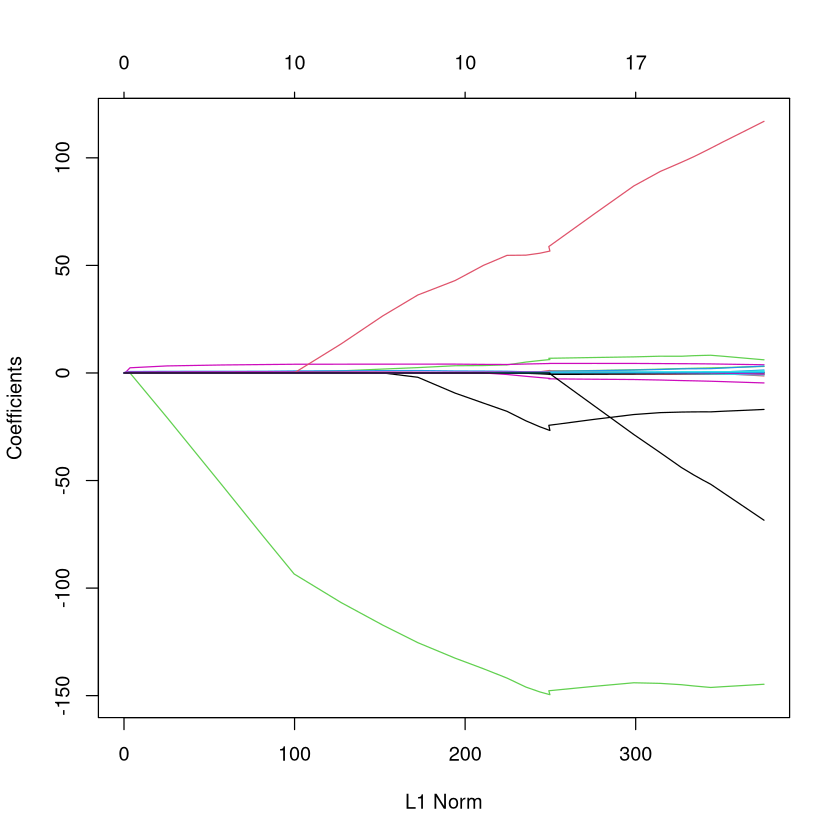

In [21]:
lasso.mod <- glmnet(x[train,], y[train], alpha = 1, lambda = grid)
plot(lasso.mod)

We can see from the coefficient plot that depending on the choice of tuning paramter, some of the coefficients will be exactly equal to zero. We now perform cross-validation and compute the associated test error.

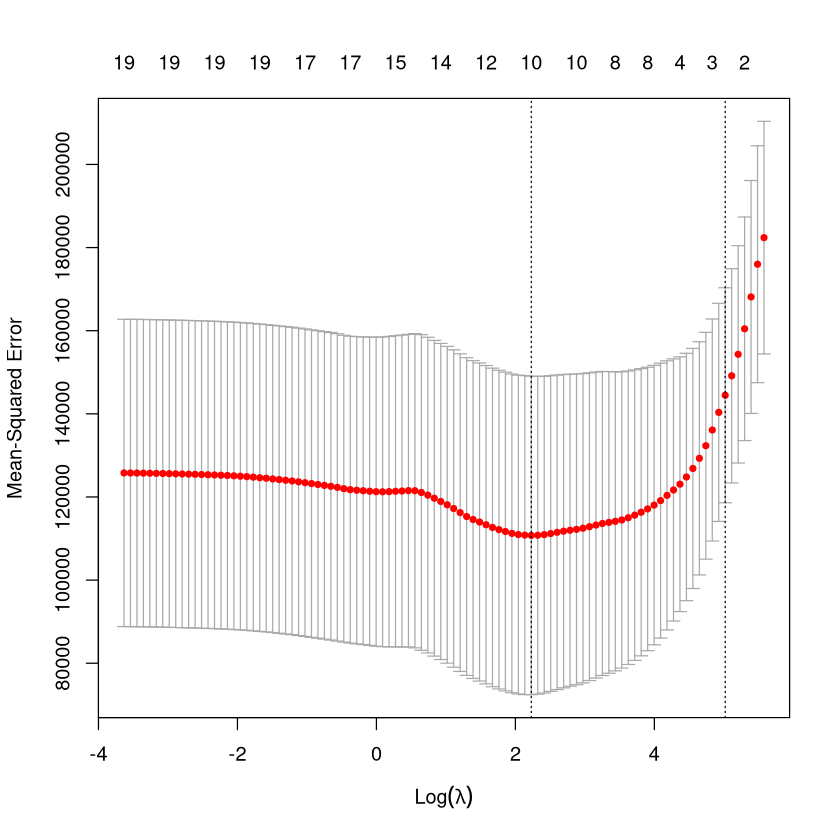

In [22]:
set.seed(1)
cv.out <- cv.glmnet(x[train,], y[train], alpha = 1)
plot(cv.out)

In [23]:
bestlam <- cv.out$lambda.min
lasso.pred <- predict(lasso.mod, s = bestlam, newx = x[test,])
mean((lasso.pred - y.test)^2)

[1] 143673.6

This is substantially lower than the test set MSE of the null model and of least squares, and very similar to the test MSE of ridge regression with $\lambda$ chosen by cross-validation.  

However, the lasso has a substantial advantage over ridge regression in that the resulting coefficient estimates are sparse. Here we see that $8$ of the $19$ coefficient estimates are exactly zero. So the lasso model with $\lambda$ chosen by cross-validation contains only eleven variables.

In [24]:
out <- glmnet(x, y, alpha = 1, lambda = grid)
lasso.coef <- predict(out, type = "coefficients", s = bestlam)[1:20,]
lasso.coef

(Intercept)         AtBat          Hits         HmRun          Runs 
   1.27479059   -0.05497143    2.18034583    0.00000000    0.00000000 
          RBI         Walks         Years        CAtBat         CHits 
   0.00000000    2.29192406   -0.33806109    0.00000000    0.00000000 
       CHmRun         CRuns          CRBI        CWalks       LeagueN 
   0.02825013    0.21628385    0.41712537    0.00000000   20.28615023 
    DivisionW       PutOuts       Assists        Errors    NewLeagueN 
-116.16755870    0.23752385    0.00000000   -0.85629148    0.00000000